### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

### Part A: Data Preprocessing and Imputation

#### 1. Load and Prepare Data

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
target = 'default.payment.next.month'

print("Original shape:", df.shape)
df.head()

Original shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


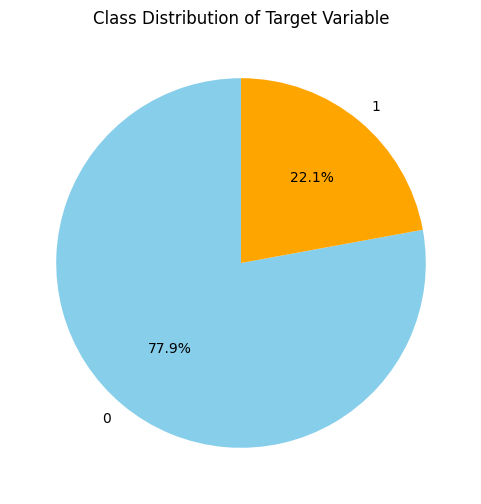

In [3]:
class_counts = df['default.payment.next.month'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue','orange'])
plt.title('Class Distribution of Target Variable')
plt.show()

    Since there is a class imbalance, I will use balanced class weights when training the logistic regression model for this task.

In [4]:
np.random.seed(42)  # for reproducibility

for col in ['AGE', 'BILL_AMT1', 'BILL_AMT2']:
    n_missing = int(0.05 * len(df))  # 5% missing values
    missing_indices = np.random.choice(df.index, n_missing, replace=False)
    df.loc[missing_indices, col] = np.nan

print("\nMissing values after MAR introduction:\n", df[['AGE', 'BILL_AMT1', 'BILL_AMT2']].isnull().sum())


Missing values after MAR introduction:
 AGE          1500
BILL_AMT1    1500
BILL_AMT2    1500
dtype: int64


#### 2. Imputation Strategy 1: Simple Imputation (Baseline) 

In [5]:
dataset_A = df.copy()

for col in ['AGE', 'BILL_AMT1', 'BILL_AMT2']:
    median_value = dataset_A[col].median()
    dataset_A[col] = dataset_A[col].fillna(median_value)

print("\nAfter Median Imputation (Dataset A):")
print(dataset_A[['AGE', 'BILL_AMT1', 'BILL_AMT2']].isnull().sum())


After Median Imputation (Dataset A):
AGE          0
BILL_AMT1    0
BILL_AMT2    0
dtype: int64


    Median is often preferred over mean for imputation because:
        1. It is less sensitive to outliers (robust measure of central tendency).
        2. It better preserves the distribution shape for skewed data.

#### 3. Imputation Strategy 2: Regression Imputation (Linear)

In [6]:
dataset_B = df.copy()

# Choosing 'AGE' for regression-based imputation
train_data = dataset_B[dataset_B['AGE'].notnull()]
test_data = dataset_B[dataset_B['AGE'].isnull()]

# Using only features without missing values
non_missing_features = [col for col in dataset_B.columns
                        if col not in ['AGE', target] and dataset_B[col].notnull().all()]

X_train = train_data[non_missing_features]
y_train = train_data['AGE']
X_test = test_data[non_missing_features]


In [7]:
# Training Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicting missing AGE values
dataset_B.loc[dataset_B['AGE'].isnull(), 'AGE'] = lr_model.predict(X_test)

print("\nAfter Linear Regression Imputation (Dataset B):")
print(dataset_B['AGE'].isnull().sum())


After Linear Regression Imputation (Dataset B):
0


    Regression imputation assumes the data is Missing At Random (MAR), meaning that the probability of missingness depends on other observed variables, not on the missing values themselves.

#### 4. Imputation Strategy 3: Regression Imputation (Non-Linear) 

In [8]:
dataset_C = df.copy()

# Choosing same column ('AGE')
train_data = dataset_C[dataset_C['AGE'].notnull()]
test_data = dataset_C[dataset_C['AGE'].isnull()]

# Using only features without missing values
non_missing_features = [col for col in dataset_C.columns
                        if col not in ['AGE', target] and dataset_C[col].notnull().all()]

X_train = train_data[non_missing_features]
y_train = train_data['AGE']
X_test = test_data[non_missing_features]


In [9]:
# Using Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Predicting missing values
dataset_C.loc[dataset_C['AGE'].isnull(), 'AGE'] = tree_model.predict(X_test)

print("\nAfter Decision Tree Imputation (Dataset C):")
print(dataset_C['AGE'].isnull().sum())


After Decision Tree Imputation (Dataset C):
0


### Part B: Model Training and Performance Assessment

#### 1. Data Split 

In [10]:
target = 'default.payment.next.month'

# Dataset D: Listwise deletion (removing rows with any NaN)
dataset_D = df.dropna().copy()

def split_data(data, target_col):
    data=data.dropna()  # deleting rows which have nulls as mentioned in the mail
    X = data.drop(columns=[target_col])
    y = data[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_A_train, X_A_test, y_A_train, y_A_test = split_data(dataset_A, target)
X_B_train, X_B_test, y_B_train, y_B_test = split_data(dataset_B, target)
X_C_train, X_C_test, y_C_train, y_C_test = split_data(dataset_C, target)
X_D_train, X_D_test, y_D_train, y_D_test = split_data(dataset_D, target)

print("Train/Test sizes:")
print(f"A: {X_A_train.shape}, {X_A_test.shape}")
print(f"B: {X_B_train.shape}, {X_B_test.shape}")
print(f"C: {X_C_train.shape}, {X_C_test.shape}")
print(f"D: {X_D_train.shape}, {X_D_test.shape}")

Train/Test sizes:
A: (24000, 24), (6000, 24)
B: (21659, 24), (5415, 24)
C: (21659, 24), (5415, 24)
D: (20582, 24), (5146, 24)


#### 2. Classifier Setup

In [11]:
scaler = StandardScaler()

def scale_data(X_train, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

X_A_train_s, X_A_test_s = scale_data(X_A_train, X_A_test)
X_B_train_s, X_B_test_s = scale_data(X_B_train, X_B_test)
X_C_train_s, X_C_test_s = scale_data(X_C_train, X_C_test)
X_D_train_s, X_D_test_s = scale_data(X_D_train, X_D_test)

#### 3. Model Evaluation

In [12]:
def train_and_evaluate(X_train, X_test, y_train, y_test, label):
    model = LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced") # classes are imbalanced so using class_wight=balanced
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n==== Classification Report for Dataset {label} ====")
    print(classification_report(y_test, y_pred, digits=4))

# Train + Evaluate for each dataset
train_and_evaluate(X_A_train_s, X_A_test_s, y_A_train, y_A_test, "A (Median Imputation)")
train_and_evaluate(X_B_train_s, X_B_test_s, y_B_train, y_B_test, "B (Linear Regression Imputation)")
train_and_evaluate(X_C_train_s, X_C_test_s, y_C_train, y_C_test, "C (Decision Tree Imputation)")
train_and_evaluate(X_D_train_s, X_D_test_s, y_D_train, y_D_test, "D (Listwise Deletion)")


==== Classification Report for Dataset A (Median Imputation) ====


              precision    recall  f1-score   support

           0     0.8665    0.6957    0.7718      4673
           1     0.3674    0.6225    0.4621      1327

    accuracy                         0.6795      6000
   macro avg     0.6170    0.6591    0.6169      6000
weighted avg     0.7561    0.6795    0.7033      6000


==== Classification Report for Dataset B (Linear Regression Imputation) ====
              precision    recall  f1-score   support

           0     0.8776    0.7001    0.7788      4218
           1     0.3829    0.6558    0.4835      1197

    accuracy                         0.6903      5415
   macro avg     0.6302    0.6780    0.6312      5415
weighted avg     0.7682    0.6903    0.7136      5415


==== Classification Report for Dataset C (Decision Tree Imputation) ====
              precision    recall  f1-score   support

           0     0.8773    0.6999    0.7786      4218
           1     0.3824    0.6550    0.4829      1197

    accuracy                 

### Part C: Comparative Analysis

#### 1. Results Comparison

In [13]:
# Train models again and collect predictions for comparison
def get_model_predictions(X_train, X_test, y_train):
    model = LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

# Generate predictions
y_A_pred = get_model_predictions(X_A_train_s, X_A_test_s, y_A_train)
y_B_pred = get_model_predictions(X_B_train_s, X_B_test_s, y_B_train)
y_C_pred = get_model_predictions(X_C_train_s, X_C_test_s, y_C_train)
y_D_pred = get_model_predictions(X_D_train_s, X_D_test_s, y_D_train)


In [14]:
# Function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }

# Compute metrics
metrics_A = compute_metrics(y_A_test, y_A_pred)
metrics_B = compute_metrics(y_B_test, y_B_pred)
metrics_C = compute_metrics(y_C_test, y_C_pred)
metrics_D = compute_metrics(y_D_test, y_D_pred)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Model': ['A (Median Imputation)', 
              'B (Linear Regression Imputation)', 
              'C (Decision Tree Imputation)', 
              'D (Listwise Deletion)'],
    'Accuracy': [metrics_A['Accuracy'], metrics_B['Accuracy'], metrics_C['Accuracy'], metrics_D['Accuracy']],
    'Precision': [metrics_A['Precision'], metrics_B['Precision'], metrics_C['Precision'], metrics_D['Precision']],
    'Recall': [metrics_A['Recall'], metrics_B['Recall'], metrics_C['Recall'], metrics_D['Recall']],
    'F1-score': [metrics_A['F1-score'], metrics_B['F1-score'], metrics_C['F1-score'], metrics_D['F1-score']]
})

# Round metrics for readability
summary_df[['Accuracy','Precision','Recall','F1-score']] = summary_df[['Accuracy','Precision','Recall','F1-score']].round(4)

print("==== Comparative Analysis Summary ====")
display(summary_df)

==== Comparative Analysis Summary ====


,Model,Accuracy,Precision,Recall,F1-score
0,A (Median Imputation),0.6795,0.3674,0.6225,0.4621
1,B (Linear Regression Imputation),0.6903,0.3829,0.6558,0.4835
2,C (Decision Tree Imputation),0.6899,0.3824,0.6550,0.4829
3,D (Listwise Deletion),0.6935,0.3833,0.6373,0.4787


#### 2. Efficacy Discussion

### 1️. Trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C)

**Listwise Deletion (Model D)** achieved the highest **accuracy (0.6935)** but a slightly lower **F1-score (0.4787)** compared to the imputation-based models (**A: 0.4621**, **B: 0.4835**, **C: 0.4829**).  
While deleting all rows with missing data ensures the model is trained on only complete records, it also reduces the dataset size, which may lead to loss of valuable information and lower generalization when missing data is common.  

In contrast, the **imputation models (A, B, C)** retained all samples by estimating missing values, leading to a better balance between precision and recall.  
Although imputation may introduce small prediction errors, it helps preserve the overall data distribution and improves **recall**, which is crucial when dealing with imbalanced classes.


### 2️. Linear vs. Non-Linear Regression Imputation

The **Linear Regression Imputation (Model B)** slightly outperformed the **Decision Tree Imputation (Model C)** (**F1 = 0.4835 vs. 0.4829**).  
This suggests that the relationship between the imputed feature (e.g., *BILL_AMT2*) and other predictors is mostly **linear**, allowing a simple model to capture it effectively.  

The **Decision Tree** could model non-linear patterns but might have slightly **overfitted** to local variations in the data, resulting in almost similar performance.


### 3️. Recommendation

Given these results, **Linear Regression Imputation (Model B)** offers the best trade-off between **accuracy, recall, and F1-score**. It maintains data completeness without unnecessary complexity.  

However, when the missing rate is low, **Listwise Deletion (Model D)** can still perform competitively with less preprocessing effort.  

Overall, **Regression-based Imputation (Model B)** is recommended for this dataset, as it handles missing data effectively while preserving the overall model performance and interpretability.
